In [1]:
from model import create_model

nn4_small2_pretrained = create_model()

Using TensorFlow backend.


In [2]:
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext=='.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')
print('metadata created')
print(metadata)

metadata created
[images/Colin_Powell/Colin_Powell_0004.jpg
 images/Colin_Powell/Colin_Powell_0006.jpg
 images/Colin_Powell/Colin_Powell_0005.jpg
 images/Colin_Powell/Colin_Powell_0008.jpg
 images/Colin_Powell/Colin_Powell_0001.jpg
 images/Colin_Powell/Colin_Powell_0003.jpg
 images/Colin_Powell/Colin_Powell_0007.jpg
 images/Colin_Powell/Colin_Powell_0002.jpg
 images/Colin_Powell/Colin_Powell_0010.jpg
 images/Colin_Powell/Colin_Powell_0009.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0005.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0002.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0006.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0007.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0004.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0010.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0003.jpg
 images/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0009.jpg
 ima

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1) #BGR
    return img[...,::-1] #RGB


alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

#combined transformation
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
embedded = np.zeros((metadata.shape[0], 128)) 

real_name = {}

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        real_name[os.path.dirname(m.image_path()[7:])] = embedded[i]
        print(i)
        print(m.name)

def real_names():
    return real_name



0
Colin_Powell
1
Colin_Powell
2
Colin_Powell
3
Colin_Powell
4
Colin_Powell
5
Colin_Powell
6
Colin_Powell
7
Colin_Powell
8
Colin_Powell
9
Colin_Powell
10
Arnold_Schwarzenegger
11
Arnold_Schwarzenegger
12
Arnold_Schwarzenegger
13
Arnold_Schwarzenegger
14
Arnold_Schwarzenegger
15
Arnold_Schwarzenegger
16
Arnold_Schwarzenegger
17
Arnold_Schwarzenegger
18
Arnold_Schwarzenegger
19
Arnold_Schwarzenegger
20
Donald_Rumsfeld
21
Donald_Rumsfeld
22
Donald_Rumsfeld
23
Donald_Rumsfeld
24
Donald_Rumsfeld
25
Donald_Rumsfeld
26
Donald_Rumsfeld
27
Donald_Rumsfeld
28
Donald_Rumsfeld
29
Donald_Rumsfeld
30
Gerhard_Schroeder
31
Gerhard_Schroeder
32
Gerhard_Schroeder
33
Gerhard_Schroeder
34
Gerhard_Schroeder
35
Gerhard_Schroeder
36
Gerhard_Schroeder
37
Gerhard_Schroeder
38
Gerhard_Schroeder
39
Gerhard_Schroeder
40
sai
41
sai
42
sai
43
sai
44
sai
45
sai
46
sai
47
sai
48
sai
49
sai
50
gali
51
gali
52
gali
53
gali
54
gali
55
gali
56
gali
57
gali
58
gali
59
gali
60
Vladimir_Putin
61
Vladimir_Putin
62
Vladimir_Pu

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

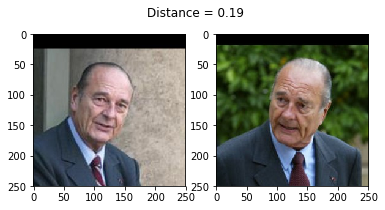

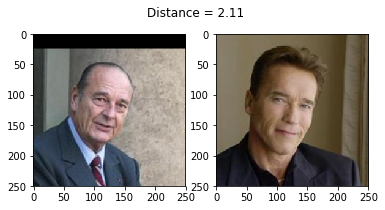

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(6,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(78, 76)
show_pair(78, 17)

In [ ]:
def recognize(embedded):
    min_dist = 100
    _id = None
    for name,emb in real_name.items():
        dist = np.sum(np.square(emb - embedded))


        if dist < min_dist:
            min_dist = dist
            _id = name
    if min_dist > 0.58:
        print(min_dist)
        return None
    else:
        print(min_dist)
        return _id

    

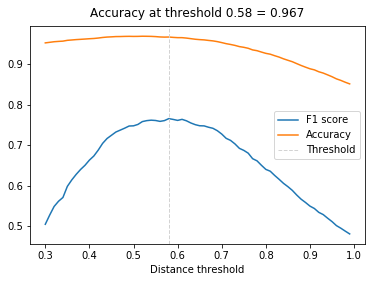

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

In [ ]:
embedded = np.zeros((1, 128))


def recognize_image(image_path):
    img = load_image(image_path)
    img = align_image(img)
    if img is not None:
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded = nn4_small2_pretrained.predict(np.expand_dims(np.array(img), axis=0))[0]
        name = recognize(embedded)
        print(name)
        return name
    return None


cap = cv2.VideoCapture(0)


# def webcam_recognize():
#     while(True): 
#         ret, frame = cap.read()
#         cv2.imwrite('temp.jpg',frame)
#         cv2.waitKey(20)
#         if 'temp.jpg' is not None:
#             name = recognize_image('temp.jpg')
#             cv2.imshow('temp',frame)
#             print(name)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
        
#     cap.release()
#     cv2.destroyAllWindows()


   # webcam_recognize()
# recognize_image('.jpg')

from mtcnn.mtcnn import MTCNN
def multiple_recognize():
    while(True):
        ret,frame = cap.read()
        cv2.imwrite('temp.jpg',frame)
        detector = MTCNN()
        image = load_image('temp.jpg')
        faces = detector.detect_faces(image)
        print(faces)
        if faces is not None:
            for face in faces:
                (x,y,w,h) = face['box']
                cv2.imwrite('temp.jpg',frame)
                if 'temp.jpg' is not None:
                    name = recognize_image('temp.jpg')
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),5)
                    cv2.imshow('Faces',frame)
                    
                    
                      
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
                
#                 cv2.imshow('parts',image[y:y+h,x:x+w])

multiple_recognize()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[{'box': [280, 304, 87, 116], 'confidence': 0.9925556778907776, 'keypoints': {'left_eye': (319, 347), 'right_eye': (356, 346), 'nose': (350, 371), 'mouth_left': (326, 397), 'mouth_right': (355, 396)}}]
[{'box': [278, 303, 91, 120], 'confidence': 0.9960553646087646, 'keypoints': {'left_eye': (311, 345), 'right_eye': (354, 343), 'nose': (338, 368), 'mouth_left': (318, 398), 'mouth_right': (350, 398)}}]
[{'box': [271, 301, 88, 116], 'confidence': 0.9968769550323486, 'keypoints': {'left_eye': (308, 346), 'right_eye': (348, 344), 'nose': (338, 368), 'mouth_left': (315, 394), 'mouth_right': (347, 392)}}]
[{'box': [270, 303, 89, 113], 'confidence': 0.9984807372093201, 'keypoints': {'left_eye': (300, 346), 'right_eye': (342, 344), 'nose': (328, 366), 'mouth_left': (309, 394), 'mouth_right': (342, 392)}}]
0.7173202037793075
None
[{'box': [268, 303, 89

0.8288250021785701
None
[{'box': [299, 174, 89, 122], 'confidence': 0.9251634478569031, 'keypoints': {'left_eye': (357, 215), 'right_eye': (384, 214), 'nose': (389, 236), 'mouth_left': (365, 268), 'mouth_right': (386, 267)}}, {'box': [144, 320, 99, 130], 'confidence': 0.829300045967102, 'keypoints': {'left_eye': (187, 368), 'right_eye': (224, 361), 'nose': (218, 392), 'mouth_left': (193, 422), 'mouth_right': (221, 416)}}]
[{'box': [267, 296, 76, 97], 'confidence': 0.9999362230300903, 'keypoints': {'left_eye': (305, 331), 'right_eye': (333, 326), 'nose': (333, 348), 'mouth_left': (316, 372), 'mouth_right': (337, 368)}}, {'box': [27, 258, 168, 201], 'confidence': 0.9966261386871338, 'keypoints': {'left_eye': (118, 331), 'right_eye': (182, 342), 'nose': (163, 385), 'mouth_left': (104, 412), 'mouth_right': (156, 420)}}]
0.6828205719540696
None
[{'box': [292, 302, 79, 106], 'confidence': 0.998456597328186, 'keypoints': {'left_eye': (331, 340), 'right_eye': (360, 338), 'nose': (358, 360), 'm

0.5044593373292966
siddharth
0.5756420772885985
siddharth
[{'box': [288, 338, 97, 124], 'confidence': 0.9999305009841919, 'keypoints': {'left_eye': (317, 387), 'right_eye': (361, 379), 'nose': (345, 406), 'mouth_left': (330, 436), 'mouth_right': (365, 431)}}]
0.5645243643357026
siddharth
[{'box': [285, 336, 95, 121], 'confidence': 0.999948263168335, 'keypoints': {'left_eye': (315, 384), 'right_eye': (359, 378), 'nose': (343, 408), 'mouth_left': (326, 433), 'mouth_right': (361, 428)}}]
0.5958749933152071
None
[{'box': [292, 319, 87, 117], 'confidence': 0.9997721314430237, 'keypoints': {'left_eye': (332, 363), 'right_eye': (370, 359), 'nose': (365, 386), 'mouth_left': (345, 414), 'mouth_right': (373, 409)}}]
[{'box': [312, 321, 87, 121], 'confidence': 0.964209258556366, 'keypoints': {'left_eye': (361, 366), 'right_eye': (392, 363), 'nose': (392, 392), 'mouth_left': (367, 419), 'mouth_right': (390, 415)}}, {'box': [40, 259, 133, 188], 'confidence': 0.9363195896148682, 'keypoints': {'left_

[{'box': [275, 298, 80, 104], 'confidence': 0.9999496936798096, 'keypoints': {'left_eye': (308, 341), 'right_eye': (344, 335), 'nose': (336, 359), 'mouth_left': (319, 382), 'mouth_right': (347, 377)}}, {'box': [3, 271, 148, 179], 'confidence': 0.9725143313407898, 'keypoints': {'left_eye': (69, 331), 'right_eye': (135, 338), 'nose': (111, 376), 'mouth_left': (64, 406), 'mouth_right': (115, 414)}}]
[{'box': [291, 299, 81, 110], 'confidence': 0.9994981288909912, 'keypoints': {'left_eye': (329, 340), 'right_eye': (360, 336), 'nose': (358, 360), 'mouth_left': (340, 386), 'mouth_right': (363, 382)}}, {'box': [53, 281, 116, 166], 'confidence': 0.9580770134925842, 'keypoints': {'left_eye': (132, 336), 'right_eye': (161, 335), 'nose': (173, 369), 'mouth_left': (133, 404), 'mouth_right': (157, 403)}}]
[{'box': [293, 303, 81, 107], 'confidence': 0.999150276184082, 'keypoints': {'left_eye': (334, 341), 'right_eye': (364, 338), 'nose': (363, 362), 'mouth_left': (343, 386), 'mouth_right': (366, 383)

[{'box': [289, 315, 83, 112], 'confidence': 0.9987769722938538, 'keypoints': {'left_eye': (331, 355), 'right_eye': (362, 353), 'nose': (360, 377), 'mouth_left': (339, 402), 'mouth_right': (362, 401)}}]
[{'box': [280, 310, 80, 108], 'confidence': 0.999087929725647, 'keypoints': {'left_eye': (320, 348), 'right_eye': (354, 347), 'nose': (350, 371), 'mouth_left': (327, 396), 'mouth_right': (353, 395)}}]
[{'box': [278, 320, 85, 112], 'confidence': 0.9888290762901306, 'keypoints': {'left_eye': (320, 361), 'right_eye': (356, 361), 'nose': (349, 389), 'mouth_left': (324, 411), 'mouth_right': (350, 410)}}, {'box': [9, 273, 142, 187], 'confidence': 0.8985030055046082, 'keypoints': {'left_eye': (96, 339), 'right_eye': (145, 342), 'nose': (144, 379), 'mouth_left': (98, 420), 'mouth_right': (134, 423)}}]
[{'box': [290, 315, 82, 108], 'confidence': 0.9951314926147461, 'keypoints': {'left_eye': (337, 354), 'right_eye': (363, 352), 'nose': (362, 376), 'mouth_left': (341, 398), 'mouth_right': (360, 397

[{'box': [281, 309, 79, 104], 'confidence': 0.9997686743736267, 'keypoints': {'left_eye': (313, 349), 'right_eye': (347, 345), 'nose': (341, 368), 'mouth_left': (324, 393), 'mouth_right': (350, 389)}}, {'box': [26, 276, 154, 182], 'confidence': 0.9861897826194763, 'keypoints': {'left_eye': (107, 340), 'right_eye': (170, 352), 'nose': (146, 391), 'mouth_left': (90, 419), 'mouth_right': (140, 431)}}]
0.3359989328208036
sindhu
[{'box': [283, 318, 79, 105], 'confidence': 0.9993910789489746, 'keypoints': {'left_eye': (322, 356), 'right_eye': (353, 353), 'nose': (352, 376), 'mouth_left': (332, 400), 'mouth_right': (355, 397)}}, {'box': [59, 284, 127, 174], 'confidence': 0.9867396354675293, 'keypoints': {'left_eye': (143, 347), 'right_eye': (176, 347), 'nose': (184, 384), 'mouth_left': (141, 417), 'mouth_right': (168, 418)}}]
[{'box': [296, 350, 85, 113], 'confidence': 0.9997994303703308, 'keypoints': {'left_eye': (324, 392), 'right_eye': (364, 392), 'nose': (347, 418), 'mouth_left': (329, 44

[{'box': [273, 314, 83, 112], 'confidence': 0.9991851449012756, 'keypoints': {'left_eye': (323, 355), 'right_eye': (348, 351), 'nose': (353, 377), 'mouth_left': (332, 401), 'mouth_right': (352, 397)}}, {'box': [26, 250, 125, 169], 'confidence': 0.9878756999969482, 'keypoints': {'left_eye': (107, 311), 'right_eye': (140, 308), 'nose': (150, 346), 'mouth_left': (109, 379), 'mouth_right': (135, 378)}}]
[{'box': [274, 315, 86, 108], 'confidence': 0.9993840456008911, 'keypoints': {'left_eye': (327, 358), 'right_eye': (352, 352), 'nose': (359, 377), 'mouth_left': (337, 403), 'mouth_right': (357, 398)}}, {'box': [17, 248, 126, 166], 'confidence': 0.9903136491775513, 'keypoints': {'left_eye': (99, 307), 'right_eye': (132, 306), 'nose': (141, 343), 'mouth_left': (99, 374), 'mouth_right': (127, 373)}}]
[{'box': [277, 318, 78, 105], 'confidence': 0.9982738494873047, 'keypoints': {'left_eye': (315, 356), 'right_eye': (345, 352), 'nose': (344, 376), 'mouth_left': (325, 399), 'mouth_right': (347, 39

None
0.5302197736036822
siddharth
[{'box': [296, 333, 80, 112], 'confidence': 0.9612756967544556, 'keypoints': {'left_eye': (341, 374), 'right_eye': (370, 369), 'nose': (371, 399), 'mouth_left': (347, 425), 'mouth_right': (370, 420)}}, {'box': [22, 283, 141, 190], 'confidence': 0.8979080319404602, 'keypoints': {'left_eye': (113, 348), 'right_eye': (156, 347), 'nose': (161, 392), 'mouth_left': (111, 431), 'mouth_right': (145, 432)}}]
[{'box': [20, 282, 141, 190], 'confidence': 0.9213532209396362, 'keypoints': {'left_eye': (109, 349), 'right_eye': (153, 349), 'nose': (157, 392), 'mouth_left': (107, 432), 'mouth_right': (142, 432)}}, {'box': [285, 334, 80, 106], 'confidence': 0.9138926863670349, 'keypoints': {'left_eye': (329, 374), 'right_eye': (360, 367), 'nose': (360, 396), 'mouth_left': (336, 424), 'mouth_right': (362, 419)}}]
[{'box': [276, 333, 77, 106], 'confidence': 0.9650892615318298, 'keypoints': {'left_eye': (321, 374), 'right_eye': (349, 365), 'nose': (351, 396), 'mouth_left':

[{'box': [270, 339, 64, 93], 'confidence': 0.9861099123954773, 'keypoints': {'left_eye': (305, 372), 'right_eye': (329, 368), 'nose': (326, 392), 'mouth_left': (314, 414), 'mouth_right': (332, 410)}}, {'box': [1, 266, 116, 164], 'confidence': 0.8640928268432617, 'keypoints': {'left_eye': (72, 323), 'right_eye': (106, 323), 'nose': (110, 357), 'mouth_left': (75, 390), 'mouth_right': (98, 390)}}]
[{'box': [257, 344, 76, 101], 'confidence': 0.9888675808906555, 'keypoints': {'left_eye': (305, 379), 'right_eye': (327, 379), 'nose': (329, 404), 'mouth_left': (303, 424), 'mouth_right': (323, 425)}}, {'box': [13, 275, 107, 154], 'confidence': 0.8721394538879395, 'keypoints': {'left_eye': (85, 326), 'right_eye': (114, 326), 'nose': (122, 359), 'mouth_left': (85, 393), 'mouth_right': (107, 393)}}]
[{'box': [282, 343, 64, 90], 'confidence': 0.9415839314460754, 'keypoints': {'left_eye': (321, 375), 'right_eye': (341, 375), 'nose': (343, 395), 'mouth_left': (326, 417), 'mouth_right': (341, 417)}}]


0.27920881407094755
sindhu
[{'box': [264, 329, 82, 103], 'confidence': 0.9999573230743408, 'keypoints': {'left_eye': (300, 367), 'right_eye': (335, 362), 'nose': (328, 386), 'mouth_left': (308, 410), 'mouth_right': (337, 406)}}, {'box': [-7, 267, 131, 175], 'confidence': 0.8325003385543823, 'keypoints': {'left_eye': (68, 326), 'right_eye': (111, 327), 'nose': (110, 363), 'mouth_left': (68, 396), 'mouth_right': (101, 397)}}]
0.32268654448037604
sindhu
0.4755295835616386
sindhu
[{'box': [290, 331, 71, 96], 'confidence': 0.9973666071891785, 'keypoints': {'left_eye': (334, 365), 'right_eye': (352, 361), 'nose': (359, 383), 'mouth_left': (341, 408), 'mouth_right': (356, 405)}}, {'box': [8, 266, 111, 162], 'confidence': 0.8709016442298889, 'keypoints': {'left_eye': (81, 322), 'right_eye': (113, 321), 'nose': (118, 356), 'mouth_left': (81, 389), 'mouth_right': (103, 390)}}]
[{'box': [258, 323, 77, 100], 'confidence': 0.9999547004699707, 'keypoints': {'left_eye': (293, 360), 'right_eye': (326,

0.5479312182155445
sindhu
[{'box': [288, 322, 68, 103], 'confidence': 0.9579671621322632, 'keypoints': {'left_eye': (325, 361), 'right_eye': (348, 360), 'nose': (343, 382), 'mouth_left': (328, 404), 'mouth_right': (345, 403)}}]
0.8475291011266229
None
[{'box': [279, 332, 76, 106], 'confidence': 0.9513301849365234, 'keypoints': {'left_eye': (319, 373), 'right_eye': (346, 368), 'nose': (342, 394), 'mouth_left': (324, 418), 'mouth_right': (345, 413)}}]
[{'box': [317, 332, 69, 99], 'confidence': 0.7921656370162964, 'keypoints': {'left_eye': (352, 371), 'right_eye': (373, 370), 'nose': (370, 392), 'mouth_left': (354, 411), 'mouth_right': (370, 411)}}]
[{'box': [243, 316, 85, 111], 'confidence': 0.9999783039093018, 'keypoints': {'left_eye': (262, 354), 'right_eye': (298, 355), 'nose': (275, 377), 'mouth_left': (266, 401), 'mouth_right': (293, 402)}}]
0.6989299946455483
None
[{'box': [249, 314, 84, 108], 'confidence': 0.9999986886978149, 'keypoints': {'left_eye': (274, 359), 'right_eye': (312

[{'box': [295, 359, 72, 101], 'confidence': 0.9492694735527039, 'keypoints': {'left_eye': (332, 398), 'right_eye': (355, 392), 'nose': (357, 413), 'mouth_left': (342, 438), 'mouth_right': (360, 433)}}, {'box': [19, 294, 108, 164], 'confidence': 0.7583398222923279, 'keypoints': {'left_eye': (98, 348), 'right_eye': (131, 349), 'nose': (137, 380), 'mouth_left': (97, 418), 'mouth_right': (122, 420)}}]
[{'box': [294, 355, 71, 104], 'confidence': 0.876843273639679, 'keypoints': {'left_eye': (331, 396), 'right_eye': (354, 389), 'nose': (355, 411), 'mouth_left': (340, 436), 'mouth_right': (357, 431)}}]
[{'box': [267, 337, 72, 103], 'confidence': 0.9978362917900085, 'keypoints': {'left_eye': (314, 378), 'right_eye': (331, 373), 'nose': (339, 396), 'mouth_left': (323, 421), 'mouth_right': (335, 417)}}]
[{'box': [256, 333, 75, 100], 'confidence': 0.9999077320098877, 'keypoints': {'left_eye': (298, 373), 'right_eye': (327, 369), 'nose': (327, 391), 'mouth_left': (306, 415), 'mouth_right': (330, 41

In [ ]:
# import gspread
# from oauth2client.service_account import ServiceAccountCredentials


# def mark_attendance():
#     scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
#     creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
#     client = gspread.authorize(creds)
    
#     sheet = client.open('Attendance').sheet1
    
#     attendance = sheet.get_all_records()
#     print(attendance)
    
# mark_attendance()